In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os

import numpy as np
import pandas as pd

import seaborn as sns 
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize']=(10,10)
plt.rcParams['font.family']='/content/drive/MyDrive/연세/YBIGTA/신입기수 프로젝트/AppleGothic.ttf'

import warnings
warnings.filterwarnings(action='ignore')


## 1. 데이터 불러오기

In [ ]:
def read_csv_by_dir(path, index_col=None):
    df_raw = pd.DataFrame()
    for files in os.listdir(path):
        if files.endswith('.csv'):
            df = pd.read_csv('/'.join([path,files]),
                            index_col=index_col)
        df_raw = pd.concat((df_raw,df),axis=0)
    return df_raw

In [ ]:
path = '/content/drive/MyDrive/신입기수 프로젝트/competition_data'
_df_rf_raw = read_csv_by_dir('/'.join([path,'rf_data']),
                            index_col=0)

_df_water_raw = read_csv_by_dir('/'.join([path,'water_data']),
                               index_col=0)

_submission_raw = pd.read_csv('/'.join([path,'sample_submission.csv']),
                             index_col=0)

In [ ]:
# raw_data 보존하기
df_rf=_df_rf_raw.copy()
df_rf.name = "rain_data"

df_water=_df_water_raw.copy()
df_water.name = "water_data"

submission=_submission_raw.copy()
submission.name = "submission"

In [ ]:
def index_to_datetime(df,format):
    df.index = pd.to_datetime(df.index,
                              format=format)
    return df

In [ ]:
df_rf=index_to_datetime(df=df_rf,format='%Y-%m-%d %H:%M')
df_water=index_to_datetime(df=df_water,format='%Y-%m-%d %H:%M')
submission=index_to_datetime(df=submission,format='%Y-%m-%d %H:%M')

In [ ]:
df_rf.sort_index(inplace=True)
df_water.sort_index(inplace=True)
submission.sort_index(inplace=True)

In [ ]:
# 데이터 시간대 확인하기
def check_datetime(df):
    print(df.name)
    print(df.select_dtypes('datetime64[ns]').head(1).index[0])
    print(df.select_dtypes('datetime64[ns]').tail(1).index[0])
    return None

check_datetime(df_rf)
check_datetime(df_water)
check_datetime(submission)

rain_data
2012-05-01 00:00:00
2022-07-18 23:50:00
water_data
2012-05-01 00:00:00
2022-07-18 23:50:00
submission
2022-06-01 00:00:00
2022-07-18 23:50:00


In [ ]:
# data target 분리하기
target = df_water.loc[:,submission.columns]
data = pd.concat((df_rf,df_water.drop(submission.columns,axis=1)),axis=1)

In [ ]:
# data와 target 하나 밀어주기 (과거데이터를 사용해야 함으로)
_target = target.reset_index(drop=True)
_data = data.reset_index(drop=True)

_data.index += 1

tot=pd.concat((_data,_target),axis=1)
tot=tot.sort_index()

tot=tot.iloc[1:-1]

target = tot.loc[:,submission.columns]
data = tot

In [ ]:
train_target=target.iloc[:-len(submission),:]
test_target=target.iloc[-len(submission):,:]

train_data=data.iloc[:-len(submission),:]
test_data=data.iloc[-len(submission):,:]

In [ ]:
# train_target.fillna(train_target.mean(),inplace=True)
# test_target.fillna(train_target.mean(),inplace=True)
# train_data.fillna(train_data.mean(),inplace=True)
# test_data.fillna(train_data.mean(),inplace=True)

In [ ]:
print('--data--')
print(train_data.shape)
print(test_data.shape)
print('--target--')
print(train_target.shape)
print(test_target.shape)


--data--
(269423, 17)
(6912, 17)
--target--
(269423, 4)
(6912, 4)


In [ ]:
train_data

,rf_10184100,rf_10184110,rf_10184140,swl,inf,sfw,ecpc,tototf,tide_level,fw_1018662,fw_1018680,fw_1018683,fw_1019630,wl_1018662,wl_1018680,wl_1018683,wl_1019630
1,0.0,0.0,0.0,24.800,555.00,219.07,24.93,555.00,445.0,469.05,0.0,729.80,540.18,314.7,300.2,290.0,275.3
2,0.0,0.0,0.0,24.794,464.60,218.86,25.15,562.90,449.0,498.00,0.0,731.48,540.18,313.7,301.2,290.0,275.3
3,0.0,0.0,0.0,24.789,478.10,218.69,25.31,576.40,451.0,490.68,0.0,726.42,540.18,311.7,301.2,290.0,276.3
4,0.0,0.0,0.0,24.789,464.80,218.69,25.31,563.10,452.0,476.21,0.0,726.42,552.17,311.7,301.2,291.0,277.3
5,0.0,0.0,0.0,24.789,478.10,218.69,25.31,576.40,450.0,476.21,0.0,707.17,564.29,311.7,301.2,291.0,277.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
269419,0.0,0.0,0.0,25.180,140.89,217.99,26.01,140.89,232.0,314.01,NaN,597.98,471.08,281.7,281.2,278.0,271.3
269420,0.0,0.0,0.0,25.180,140.94,217.99,26.01,140.94,220.0,285.72,NaN,575.57,493.58,279.7,279.2,278.0,272.3
269421,0.0,0.0,0.0,25.180,141.07,217.99,26.01,141.07,208.0,274.78,NaN,501.04,505.03,278.7,277.2,277.0,272.3
269422,0.0,0.0,0.0,25.180,141.01,217.99,26.01,141.01,196.0,269.40,NaN,425.89,505.03,277.7,276.2,276.0,271.3


In [ ]:
train_data.corr()

,rf_10184100,rf_10184110,rf_10184140,swl,inf,sfw,ecpc,tototf,tide_level,fw_1018662,fw_1018680,fw_1018683,fw_1019630,wl_1018662,wl_1018680,wl_1018683,wl_1019630
rf_10184100,1.000000,0.338082,0.411417,-0.022732,0.097689,-0.032908,0.032909,0.097436,0.007849,0.084444,NaN,0.084298,0.081558,0.096005,0.093648,0.094019,0.092128
rf_10184110,0.338082,1.000000,0.440414,-0.047978,0.108710,-0.048196,0.048197,0.109152,0.006585,0.094603,NaN,0.095263,0.092668,0.106908,0.103748,0.104136,0.101695
rf_10184140,0.411417,0.440414,1.000000,-0.027649,0.097614,-0.032548,0.032548,0.098067,0.003518,0.088212,NaN,0.086264,0.082770,0.097811,0.094940,0.095523,0.092624
swl,-0.022732,-0.047978,-0.027649,1.000000,-0.094940,0.560214,-0.560224,-0.098287,-0.011754,-0.070728,NaN,-0.102593,-0.092866,-0.099971,-0.110630,-0.105757,-0.092281
inf,0.097689,0.108710,0.097614,-0.094940,1.000000,-0.172239,0.172239,0.986628,0.052428,0.874075,NaN,0.895933,0.873571,0.884096,0.861209,0.849330,0.793396
sfw,-0.032908,-0.048196,-0.032548,0.560214,-0.172239,1.000000,-1.000000,-0.174699,-0.012727,-0.110048,NaN,-0.168066,-0.172680,-0.163338,-0.189222,-0.193674,-0.164454
ecpc,0.032909,0.048197,0.032548,-0.560224,0.172239,-1.000000,1.000000,0.174700,0.012726,0.110049,NaN,0.168068,0.172682,0.163339,0.189222,0.193674,0.164455
tototf,0.097436,0.109152,0.098067,-0.098287,0.986628,-0.174699,0.174700,1.000000,0.054551,0.881751,NaN,0.901694,0.877894,0.890710,0.867010,0.855218,0.799508
tide_level,0.007849,0.006585,0.003518,-0.011754,0.052428,-0.012727,0.012726,0.054551,1.000000,0.014186,NaN,-0.068142,0.072300,0.014847,0.019709,0.024991,0.085550
fw_1018662,0.084444,0.094603,0.088212,-0.070728,0.874075,-0.110048,0.110049,0.881751,0.014186,1.000000,NaN,0.793550,0.938262,0.956616,0.935689,0.929528,0.863516


## 2. eda

In [ ]:
pd.set_option('display.max_rows', None)
train_data.isnull().sum()

rf_10184100         0
rf_10184110         0
rf_10184140         0
swl               707
inf               707
sfw               707
ecpc              707
tototf            707
tide_level       4923
fw_1018662      15164
fw_1018680     189936
fw_1018683       1279
fw_1019630         59
wl_1018662         59
wl_1018680         59
wl_1018683         59
wl_1019630         59
dtype: int64

In [ ]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 269423 entries, 1 to 269423
Data columns (total 17 columns):
 #   Column       Non-Null Count   Dtype  
---  ------       --------------   -----  
 0   rf_10184100  269423 non-null  float64
 1   rf_10184110  269423 non-null  float64
 2   rf_10184140  269423 non-null  float64
 3   swl          268716 non-null  float64
 4   inf          268716 non-null  float64
 5   sfw          268716 non-null  float64
 6   ecpc         268716 non-null  float64
 7   tototf       268716 non-null  float64
 8   tide_level   264500 non-null  float64
 9   fw_1018662   254259 non-null  float64
 10  fw_1018680   79487 non-null   float64
 11  fw_1018683   268144 non-null  float64
 12  fw_1019630   269364 non-null  float64
 13  wl_1018662   269364 non-null  float64
 14  wl_1018680   269364 non-null  float64
 15  wl_1018683   269364 non-null  float64
 16  wl_1019630   269364 non-null  float64
dtypes: float64(17)
memory usage: 34.9 MB


#rf

In [ ]:
pd.set_option('display.max_rows', 10)

In [ ]:
train_data[['rf_10184100','rf_10184110','rf_10184140']].value_counts()

rf_10184100  rf_10184110  rf_10184140
0.0          0.0          0.0            259089
             1.0          0.0              1863
1.0          0.0          0.0              1623
0.0          0.0          1.0              1430
             1.0          1.0               592
                                          ...  
3.0          4.0          9.0                 1
                          7.0                 1
                          1.0                 1
             3.0          12.0                1
24.0         1.0          0.0                 1
Length: 517, dtype: int64

,rf_10184100,rf_10184110,rf_10184140
rf_10184100,1.000000,0.338082,0.411417
rf_10184110,0.338082,1.000000,0.440414
rf_10184140,0.411417,0.440414,1.000000


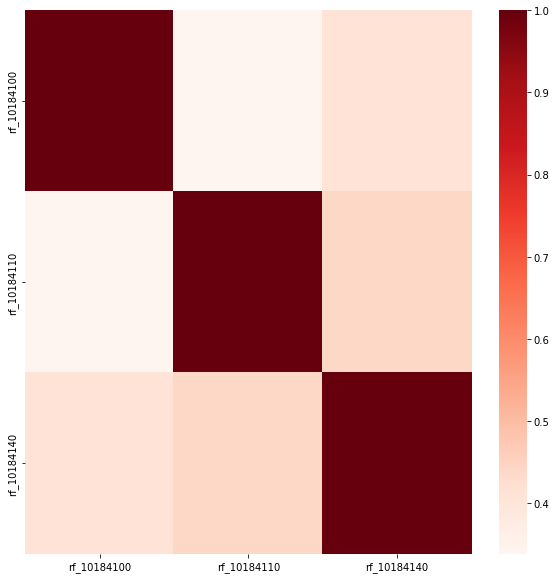

In [ ]:
rainfall_cor = train_data[['rf_10184100','rf_10184110','rf_10184140']].corr()
sns.heatmap(rainfall_cor, cmap='Reds')
rainfall_cor

In [ ]:
tmp = train_data[['rf_10184100','rf_10184110','rf_10184140']]
idx = tmp[(tmp['rf_10184100'] == 0.0)|(tmp['rf_10184110'] == 0.0)|(tmp['rf_10184140'] == 0.0)].index
tmp3 = tmp.drop(idx)

In [ ]:
tmp3.corr()

,rf_10184100,rf_10184110,rf_10184140
rf_10184100,1.000000,0.301191,0.385498
rf_10184110,0.301191,1.000000,0.456177
rf_10184140,0.385498,0.456177,1.000000


In [ ]:
tt=pd.concat((tmp3, train_data.wl_1018662, train_data.wl_1018680, train_data.wl_1018683, train_data.wl_1019630),axis=1)

In [ ]:
tt.corr()

,rf_10184100,rf_10184110,rf_10184140,wl_1018662,wl_1018680,wl_1018683,wl_1019630
rf_10184100,1.000000,0.301191,0.385498,0.130312,0.123763,0.128304,0.126746
rf_10184110,0.301191,1.000000,0.456177,0.156274,0.150236,0.155922,0.168566
rf_10184140,0.385498,0.456177,1.000000,0.131311,0.126237,0.130249,0.128512
wl_1018662,0.130312,0.156274,0.131311,1.000000,0.991150,0.990986,0.949497
wl_1018680,0.123763,0.150236,0.126237,0.991150,1.000000,0.995218,0.957848
wl_1018683,0.128304,0.155922,0.130249,0.990986,0.995218,1.000000,0.972335
wl_1019630,0.126746,0.168566,0.128512,0.949497,0.957848,0.972335,1.000000


In [ ]:
aaaa=train_data['swl'][27000:27500]
bbbb=train_data['inf'][27000:27500]
cccc=train_data['sfw'][27000:27500]
dddd=train_data['ecpc'][27000:27500]

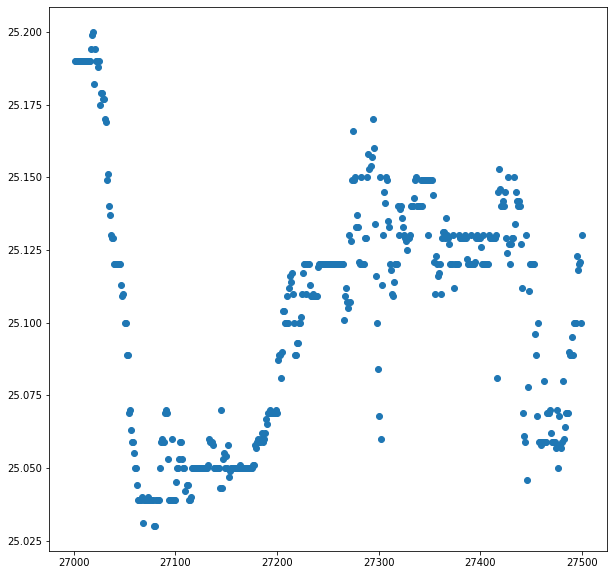

In [ ]:
x = aaaa.index
y1 = aaaa
y2 = bbbb
y3 = cccc
y4 = dddd

plt.scatter(x, y1)
# plt.plot(x, y2)
# plt.plot(x, y3)
# plt.plot(x, y4)

#swl, inf, sfw, ecpc,tototf

In [ ]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [ ]:
train_data[train_data['swl'].isnull()].isnull().sum()

rf_10184100      0
rf_10184110      0
rf_10184140      0
swl            707
inf            707
sfw            707
ecpc           707
tototf         707
tide_level       3
fw_1018662      24
fw_1018680     686
fw_1018683       1
fw_1019630       0
wl_1018662       0
wl_1018680       0
wl_1018683       0
wl_1019630       0
dtype: int64

In [ ]:
pd.set_option('display.max_rows', 10)

In [ ]:
train_data[train_data['swl'].isnull()]

,rf_10184100,rf_10184110,rf_10184140,swl,inf,sfw,ecpc,tototf,tide_level,fw_1018662,fw_1018680,fw_1018683,fw_1019630,wl_1018662,wl_1018680,wl_1018683,wl_1019630
13201,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,557.0,381.12,0.0,340.70,337.86,298.7,275.2,272.0,256.3
68082,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,605.0,598.25,0.0,904.58,974.40,324.7,310.2,313.0,306.3
68084,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,660.0,558.57,0.0,910.12,974.40,319.7,309.2,313.0,306.3
68085,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,683.0,535.44,0.0,927.37,974.40,318.7,308.2,313.0,306.3
68086,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,699.0,527.84,0.0,936.00,974.40,316.7,309.2,313.0,306.3
68087,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,713.0,512.81,0.0,944.63,974.40,316.7,309.2,314.0,306.3
68088,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,722.0,512.81,0.0,945.90,974.40,316.7,310.2,314.0,306.3
68090,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,725.0,512.81,0.0,889.75,974.40,318.7,312.2,314.0,306.3
68091,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,720.0,527.84,0.0,915.67,974.40,321.7,313.2,314.0,306.3
68092,0.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,711.0,550.81,0.0,881.11,974.40,324.7,315.2,315.0,306.3


│   ├ swl : 팔당댐 현재수위 (단위: El.m)

│   ├ inf : 팔당댐 유입량 (단위: m^3/s)

│   ├ sfw : 팔당댐 저수량 (단위: 만m^3)

│   ├ ecpc : 팔당댐 공용량 (단위: 백만m^3)

│   ├ tototf : 총 방류량 (단위: m^3/s)

swl inf sfw ecpc 필요한가?

,tototf,wl_1018662,wl_1018680,wl_1018683,wl_1019630
tototf,1.000000,0.897170,0.875214,0.863948,0.808982
wl_1018662,0.897170,1.000000,0.991150,0.990986,0.949497
wl_1018680,0.875214,0.991150,1.000000,0.995218,0.957848
wl_1018683,0.863948,0.990986,0.995218,1.000000,0.972335
wl_1019630,0.808982,0.949497,0.957848,0.972335,1.000000


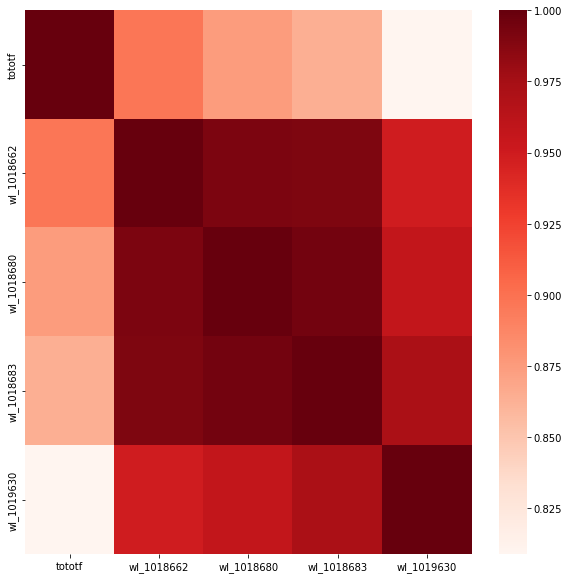

In [ ]:
idx2 = []

push_num = 18

for i in range(push_num):
  idx2.append(i+1)

m = pd.Series(train_data['tototf'][50:50+push_num] , index = idx2)

_tide = train_data['tototf'].reset_index(drop=True)
_tide.index += push_num
__tide = pd.concat([m, _tide])
tide = __tide[:-(push_num-1)]

mm = pd.concat((tide,train_data[['wl_1018662','wl_1018680', 'wl_1018683', 'wl_1019630']]),axis=1)

tot_cor = mm.corr()
sns.heatmap(tot_cor, cmap='Reds')
tot_cor

# for i in range(0, 150): 
#   idx2 = []

#   push_num = i

#   for i in range(push_num):
#     idx2.append(i+1)

#   m = pd.Series(train_data['tototf'][50:50+push_num] , index = idx2)



#   _tide = train_data['tototf'].reset_index(drop=True)
#   _tide.index += push_num
#   __tide = pd.concat([m, _tide])
#   tide = __tide[:-(push_num-1)]

#   mm = pd.concat((tide,train_data[['wl_1018662','wl_1018680', 'wl_1018683', 'wl_1019630']]),axis=1)

#   tot_cor = mm.corr()
#   print(i, tot_cor.sum()[0])

#tide_level

In [ ]:
#https://koreascience.kr/article/CFKO200211921187700.pdf
#https://scienceon.kisti.re.kr/commons/util/originalView.do?cn=JAKO200311921618036&oCn=JAKO200311921618036&dbt=JAKO&journal=NJOU00291564

In [ ]:
train_data[train_data['tide_level'].isnull()].isnull().sum()

rf_10184100    0
rf_10184110    0
rf_10184140    0
swl            3
inf            3
              ..
fw_1019630     0
wl_1018662     0
wl_1018680     0
wl_1018683     0
wl_1019630     0
Length: 17, dtype: int64

In [ ]:
train_data[train_data['tide_level'].isnull()]

,rf_10184100,rf_10184110,rf_10184140,swl,inf,sfw,ecpc,tototf,tide_level,fw_1018662,fw_1018680,fw_1018683,fw_1019630,wl_1018662,wl_1018680,wl_1018683,wl_1019630
194,0.0,0.0,0.0,24.949,261.80,224.19,19.81,261.80,NaN,325.72,0.0,309.42,376.45,287.7,283.2,273.0,260.3
308,0.0,0.0,0.0,24.940,401.80,223.87,20.13,401.80,NaN,427.30,0.0,458.60,493.58,303.7,295.2,284.0,271.3
1360,0.0,0.0,0.0,25.039,352.70,227.41,16.60,352.70,NaN,319.84,0.0,-1115.14,974.40,296.7,304.2,304.0,313.3
1378,0.0,0.0,0.0,24.960,-366.00,224.57,19.43,327.20,NaN,836.77,0.0,1125.12,1286.29,349.7,346.2,338.0,322.3
1379,0.0,0.0,0.0,24.960,-366.00,224.57,19.43,327.20,NaN,789.50,0.0,960.29,1249.45,347.7,344.2,333.0,320.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
265029,0.0,0.0,0.0,25.170,124.39,217.63,26.37,124.39,NaN,374.74,NaN,606.56,666.09,294.7,295.2,293.0,284.3
265030,0.0,0.0,0.0,25.180,739.72,217.99,26.01,124.72,NaN,362.15,NaN,448.36,652.89,293.7,293.2,291.0,282.3
266200,0.0,0.0,0.0,25.120,169.48,215.79,28.21,169.48,NaN,NaN,NaN,477.48,301.39,266.7,268.2,262.0,252.3
266291,0.0,0.0,0.0,25.140,165.17,216.52,27.48,165.17,NaN,NaN,NaN,212.61,267.05,262.7,261.2,256.0,248.3


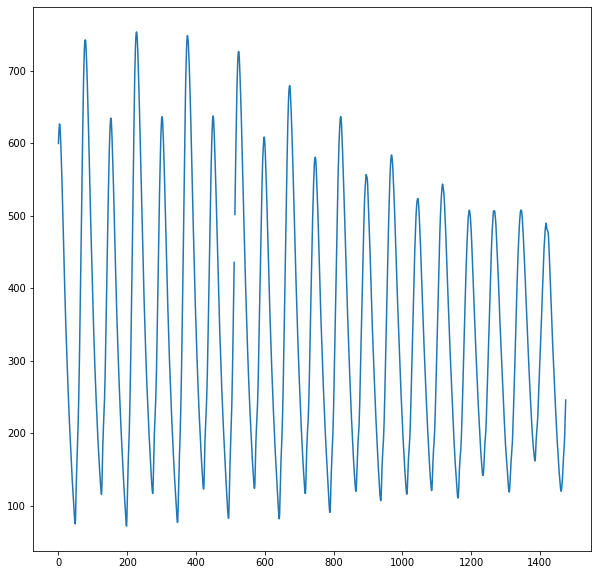

In [ ]:
ttmp = train_data['tide_level'][5000:6500]
plt.plot(range(len(ttmp)), ttmp)

결측치 처리 : 보간

In [ ]:
#!pip install missingno

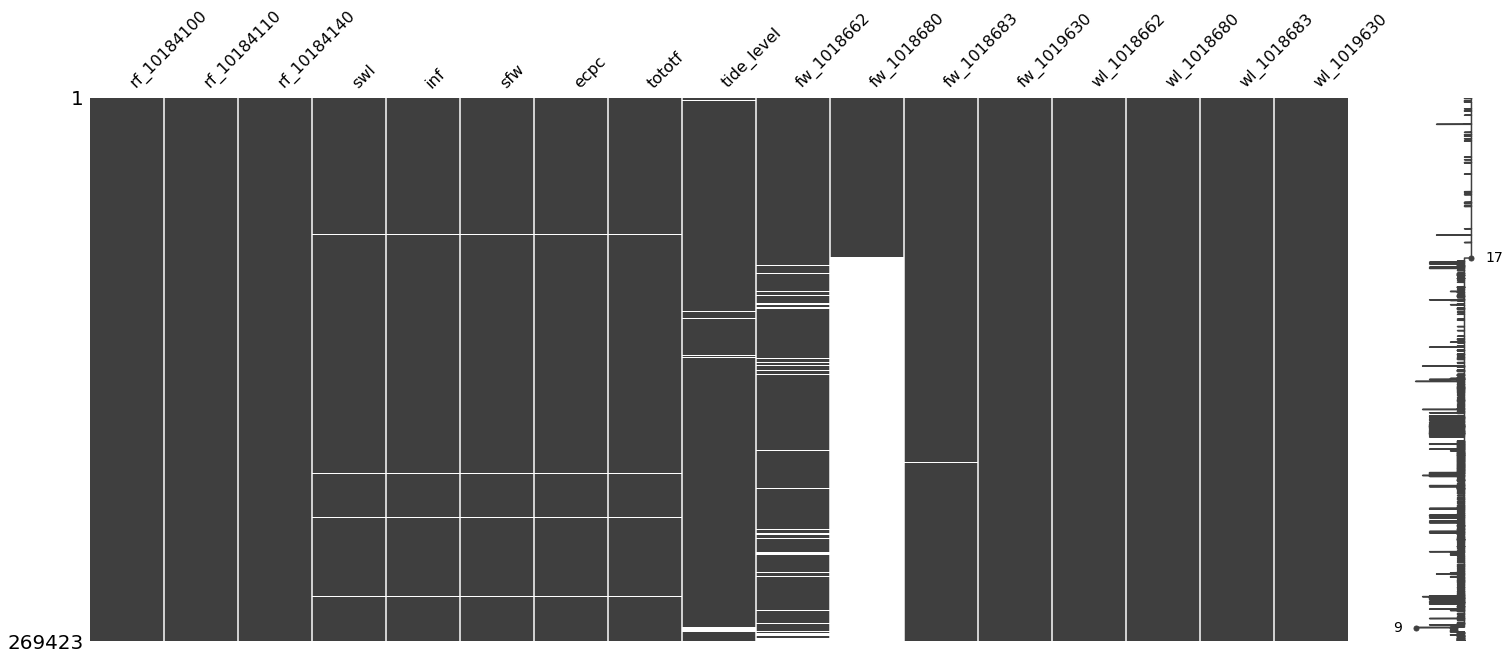

In [ ]:
import missingno as msno
msno.matrix(train_data)

2010/10/14 ~ 10/31 tide level 없음 -> 보간X
지울까? 채울까?

,tide_level,wl_1018662,wl_1018680,wl_1018683,wl_1019630
tide_level,1.000000,0.014847,0.019709,0.024991,0.085550
wl_1018662,0.014847,1.000000,0.991150,0.990986,0.949497
wl_1018680,0.019709,0.991150,1.000000,0.995218,0.957848
wl_1018683,0.024991,0.990986,0.995218,1.000000,0.972335
wl_1019630,0.085550,0.949497,0.957848,0.972335,1.000000


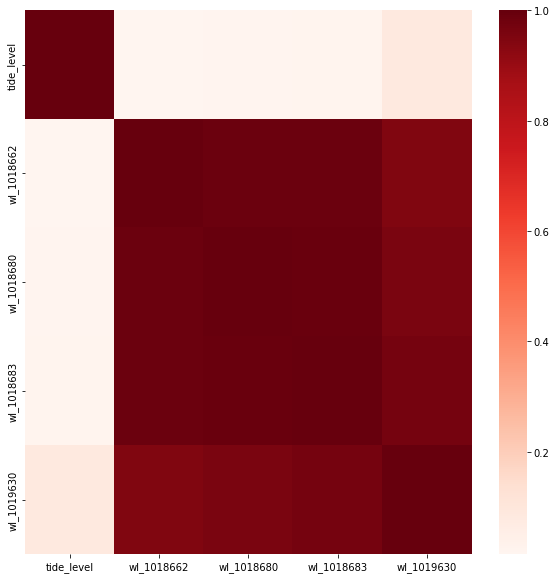

In [ ]:
tide_cor = train_data[['tide_level','wl_1018662','wl_1018680', 'wl_1018683', 'wl_1019630']].corr()
sns.heatmap(tide_cor, cmap='Reds')
tide_cor

위치 차이?

,tide_level,wl_1018662,wl_1018680,wl_1018683,wl_1019630
tide_level,1.000000,0.307034,0.333018,0.346658,0.363547
wl_1018662,0.307034,1.000000,0.991150,0.990986,0.949497
wl_1018680,0.333018,0.991150,1.000000,0.995218,0.957848
wl_1018683,0.346658,0.990986,0.995218,1.000000,0.972335
wl_1019630,0.363547,0.949497,0.957848,0.972335,1.000000


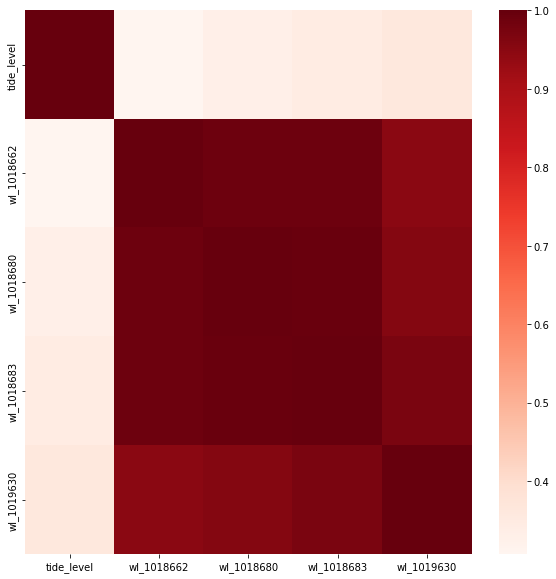

In [ ]:
idx2 = []

push_num = 22

for i in range(push_num):
  idx2.append(i+1)

m = pd.Series(train_data['tide_level'][50:50+push_num] , index = idx2)

_tide = train_data['tide_level'].reset_index(drop=True)
_tide.index += push_num
__tide = pd.concat([m, _tide])
tide = __tide[:-(push_num-1)]

mm = pd.concat((tide,train_data[['wl_1018662','wl_1018680', 'wl_1018683', 'wl_1019630']]),axis=1)

tide_cor2 = mm.corr()
sns.heatmap(tide_cor2, cmap='Reds')
tide_cor2

# for i in range(0, 150): 
#   idx2 = []

#   push_num = i

#   for i in range(push_num):
#     idx2.append(i+1)

#   m = pd.Series(train_data['tide_level'][50:50+push_num] , index = idx2)



#   _tide = train_data['tide_level'].reset_index(drop=True)
#   _tide.index += push_num
#   __tide = pd.concat([m, _tide])
#   tide = __tide[:-(push_num-1)]

#   mm = pd.concat((tide,train_data[['wl_1018662','wl_1018680', 'wl_1018683', 'wl_1019630']]),axis=1)

#   tide_cor2 = mm.corr()
#   print(i, tide_cor2.sum()[0])

#fw

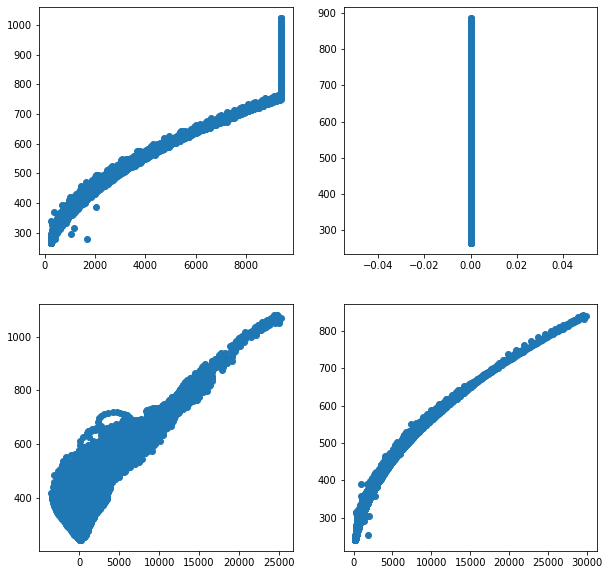

In [ ]:
x1 = train_data['fw_1018662']
y1 = train_data['wl_1018662']

x2 = train_data['fw_1018680']
y2 = train_data['wl_1018680']

x3 = train_data['fw_1018683']
y3 = train_data['wl_1018683']

x4 = train_data['fw_1019630']
y4 = train_data['wl_1019630']

plt.subplot(221)
plt.scatter(x1, y1)

plt.subplot(222)
plt.scatter(x2, y2)

plt.subplot(223)
plt.scatter(x3, y3)

plt.subplot(224)
plt.scatter(x4, y4)

plt.show()

In [ ]:
#수위-유량 관계곡선 rating curve

In [ ]:
y1 = train_data['wl_1018662']
y1.sort_values(ascending = False).head(10)

226021    1287.7
226024    1287.7
226022    1287.7
226023    1286.7
226018    1286.7
226025    1286.7
226020    1286.7
226027    1285.7
226028    1284.7
226026    1284.7
Name: wl_1018662, dtype: float64

In [ ]:
train_data[train_data['wl_1018662'] > 1200]

,rf_10184100,rf_10184110,rf_10184140,swl,inf,sfw,ecpc,tototf,tide_level,fw_1018662,fw_1018680,fw_1018683,fw_1019630,wl_1018662,wl_1018680,wl_1018683,wl_1019630
225995,0.0,0.0,0.0,24.41,17988.0,188.90,55.10,18302.0,603.0,NaN,NaN,20496.22,27681.93,1206.7,1076.2,997.0,820.3
225996,0.0,0.0,0.0,24.34,16324.0,186.27,57.73,18090.0,579.0,NaN,NaN,20742.84,27770.76,1216.7,1080.2,1016.0,821.3
225997,0.0,0.0,0.0,24.38,16604.0,187.77,56.23,18170.0,563.0,NaN,NaN,21422.72,27859.75,1222.7,1087.2,1007.0,822.3
225998,0.0,0.0,0.0,24.42,17320.0,189.28,54.72,18163.0,544.0,NaN,NaN,21548.16,27948.88,1231.7,1093.2,1016.0,822.3
225999,0.0,0.0,0.0,24.43,18956.0,189.66,54.34,18122.0,525.0,NaN,NaN,21772.89,27948.88,1237.7,1097.2,1026.0,821.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226074,0.0,0.0,0.0,24.70,14906.0,200.10,43.90,15674.0,422.0,NaN,NaN,21516.73,26280.27,1204.7,1081.2,997.0,803.3
226075,0.0,0.0,0.0,24.62,13841.0,196.96,47.04,15574.0,405.0,NaN,NaN,21228.52,26280.27,1204.7,1080.2,1006.0,801.3
226076,0.0,0.0,0.0,24.62,14368.0,196.96,47.04,15544.0,391.0,NaN,NaN,21404.64,26107.67,1201.7,1080.2,1004.0,801.3
226077,0.0,0.0,0.0,24.62,13690.0,196.96,47.04,14883.0,379.0,NaN,NaN,21482.50,26107.67,1202.7,1079.2,1014.0,799.3


비 많이 온 날 이상치인 듯 한데,
이 때의 rf 비 데이터가 없음

#wl

In [ ]:
train_data[train_data['wl_1018680'].isnull()].isnull().sum()

rf_10184100     0
rf_10184110     0
rf_10184140     0
swl             0
inf             0
               ..
fw_1019630     57
wl_1018662     59
wl_1018680     59
wl_1018683     59
wl_1019630     59
Length: 17, dtype: int64

In [ ]:
train_data[train_data['wl_1018680'].isnull()]
#2017-06-26  11:30:00 AM ~ 2017-06-26  9:00:00 PM
#2020-10-15  10:40:00 AM

,rf_10184100,rf_10184110,rf_10184140,swl,inf,sfw,ecpc,tototf,tide_level,fw_1018662,fw_1018680,fw_1018683,fw_1019630,wl_1018662,wl_1018680,wl_1018683,wl_1019630
140613,0.0,0.0,0.0,25.006,0.00,211.65,32.35,98.76,364.0,1716.75,NaN,736.89,2410.83,NaN,NaN,NaN,NaN
140614,0.0,0.0,0.0,24.984,0.00,210.86,33.15,98.87,347.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140615,0.0,0.0,0.0,24.979,0.00,210.66,33.34,98.90,331.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140616,0.0,0.0,0.0,24.979,0.00,210.66,33.34,98.90,315.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140617,0.0,0.0,0.0,25.090,13.00,214.69,29.31,115.00,300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
140667,0.0,0.0,0.0,25.100,216.10,215.05,28.95,114.40,632.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140668,0.0,0.0,0.0,25.109,317.75,215.39,28.61,114.35,618.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140669,0.0,0.0,0.0,25.109,317.75,215.39,28.61,114.35,602.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
140670,0.0,0.0,0.0,25.109,317.75,215.39,28.61,114.35,586.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


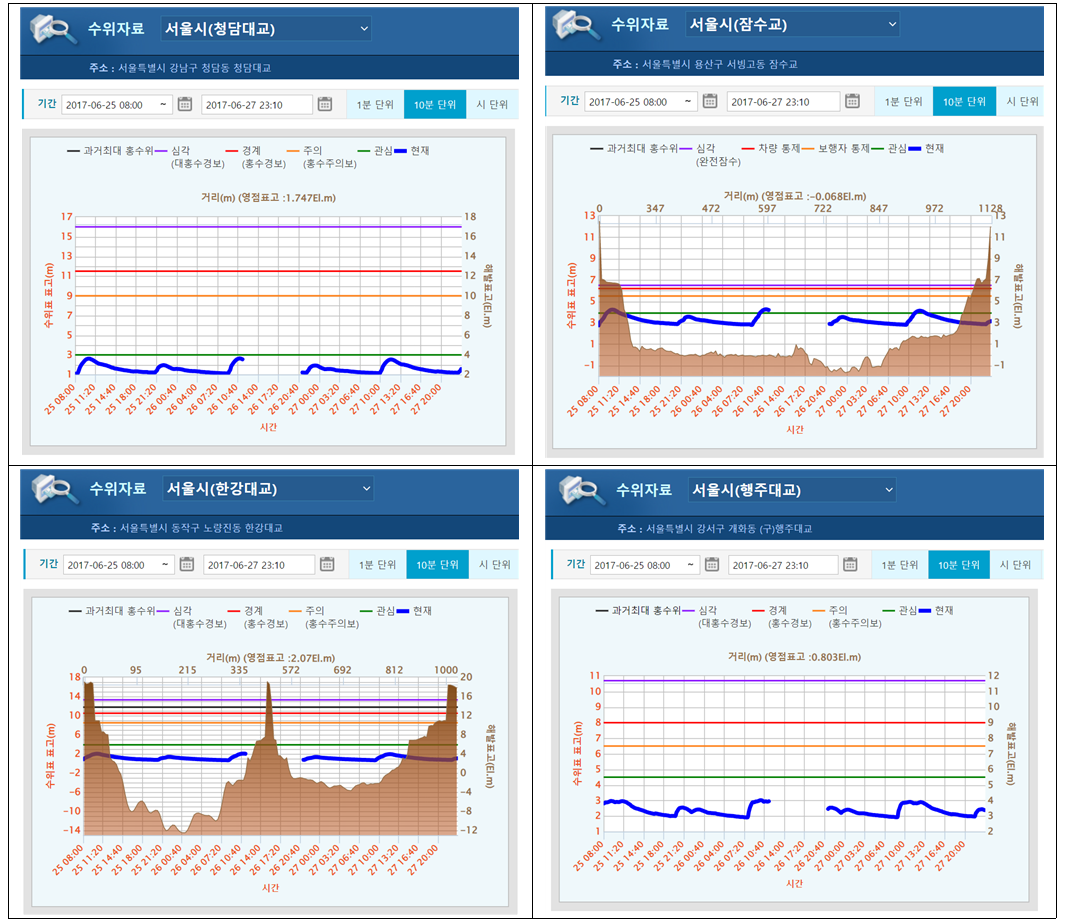

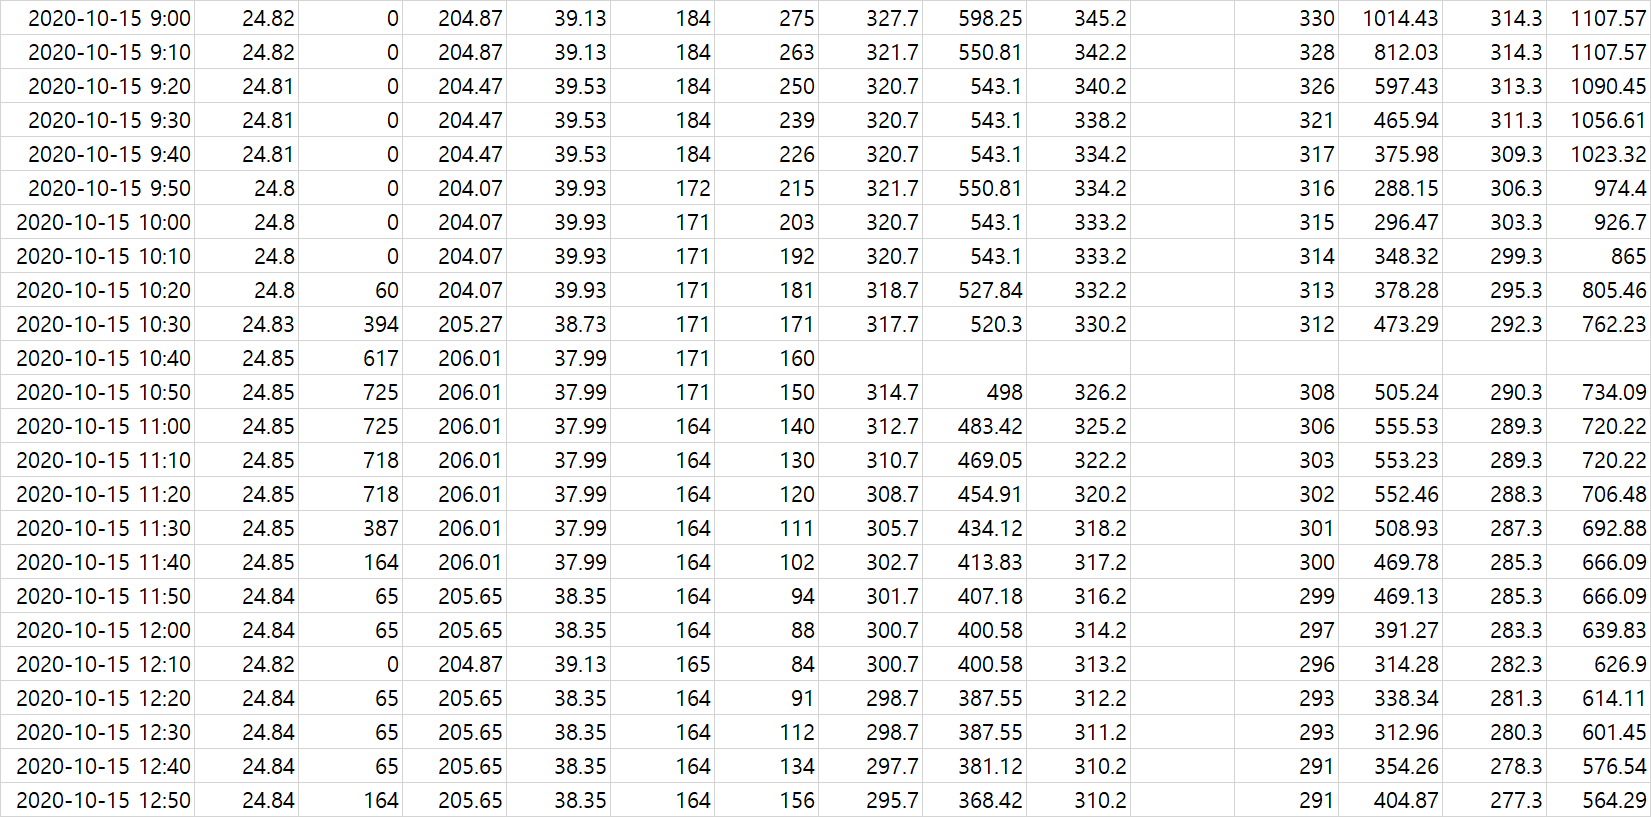

In [ ]:
#수위 데이터
#http://www.hrfco.go.kr/popup/waterlevelPopup.do?Obscd=1018662

In [ ]:
pd.set_option('display.max_rows', 10)
pd.set_option('display.max_columns', 20)